# Two Sigma Connect: Rental Listing Inquiries

This is a kaggle competition in which the goal is to predict how popular an apartment rental listing will be based on the listing content like: text description, photos, number of bedrooms, price, etc.

The data for this competition can be found <a href="https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data">here.</a>

In [41]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
#First look at the dataset...
train_df = pd.read_json('./Data/train.json')
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


**Text Features:**
- description, display_address, features, street_address

**Numerical Features:**
- bathrooms, bedrooms, latitude, longitude, price

**Date Features:**
- created

**Image Features:**
- photos

**NOTE:** The target feature is "interest_level" which can be one of three values: high, medium, or low.

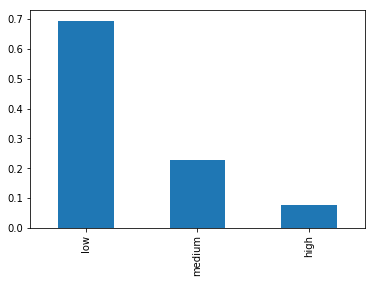

In [3]:
##First lets look at the distribution of our target feature, "interest_level"
train_df.interest_level.value_counts(normalize=True).plot.bar()

As we see from above, the data is heavily skewed. That is, roughly 70% of rental listings have low interest, 20% have medium interest and 10% has high interest.

This means that if we create a naive predictor that guessses low interest for all listings, we would be roughly 70% accurate.

# Data Exploration: Numerical Features

Here we will take a closer look at the numerical features:
- Bathrooms
- Bedrooms
- Price
- Latitude
- Longitude
- Created

### Bathrooms

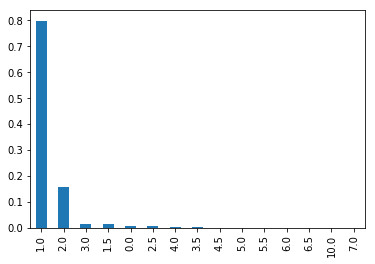

In [4]:
#Look at distribution of bathrooms (How many listings have 1 bathroom? 2? 2.5?)
train_df.bathrooms.value_counts(normalize=True).plot.bar()

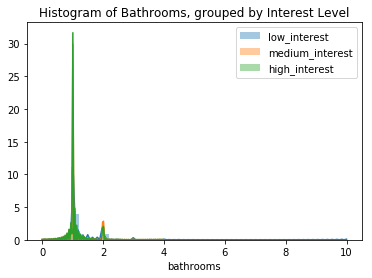

In [5]:
#How does bathroom feature correlate with interest_level? Lets use histogram grouped by interest_level

# Histograms for each interest_level
sns.distplot(a=train_df[train_df['interest_level'] == 'low'].bathrooms, label='low_interest', kde=True)
sns.distplot(a=train_df[train_df['interest_level'] == 'medium'].bathrooms, label='medium_interest', kde=True)
sns.distplot(a=train_df[train_df['interest_level'] == 'high'].bathrooms, label='high_interest', kde=True)

# Add title and legend
plt.title("Histogram of Bathrooms, grouped by Interest Level")
plt.legend()

Pretty hard to see whats going on with the overlap, lets try plotting them on three different graphs.

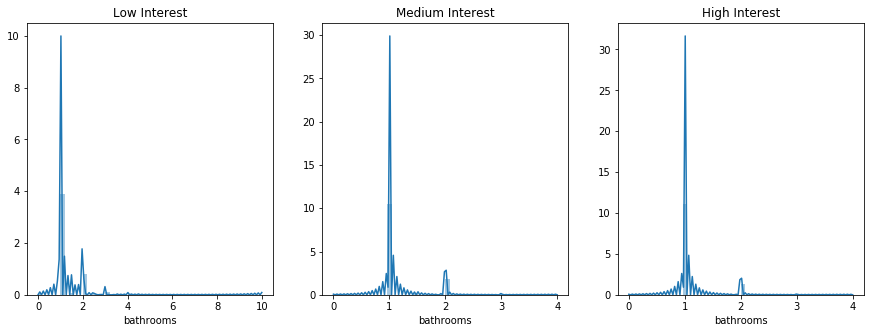

In [6]:
plt.figure(figsize=(15,5))

# Histograms for each interest_level
plt.subplot(1,3,1)
plt.title("Low Interest")
sns.distplot(a=train_df[train_df['interest_level'] == 'low'].bathrooms, label='low_interest', kde=True)
plt.subplot(1,3,2)
plt.title("Medium Interest")
sns.distplot(a=train_df[train_df['interest_level'] == 'medium'].bathrooms, label='medium_interest', kde=True)
plt.subplot(1,3,3)
plt.title("High Interest")
sns.distplot(a=train_df[train_df['interest_level'] == 'high'].bathrooms, label='high_interest', kde=True)


So, we can see a similar distribution for bathrooms for all interest levels. This likely means that number of bathrooms do not have a big correlation with interest levels.

**NOTE:** Another way to see distribution w.r.t interest_level is to use a violin plot.

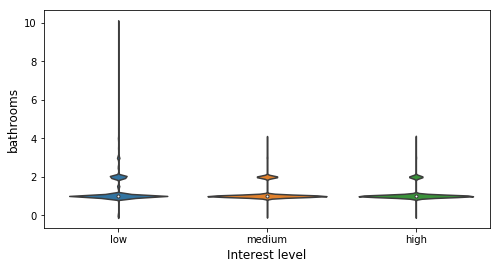

In [7]:
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bathrooms', data=train_df, order=['low','medium','high'])
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bathrooms', fontsize=12)
plt.show()

Okay, so the violin plot captures the same information as the histogram above and we can see that all three interest levels have similar distribution.

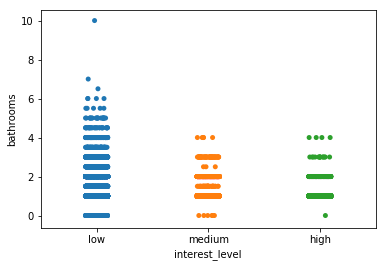

In [8]:
sns.stripplot(x="interest_level", y="bathrooms", data=train_df, order=['low','medium','high'])

So from this above figure we can tell that people are not interested in houses with a lot of bathrooms (5+). Medium and High interest levels are capped at a maximum of 4 bathrooms.

## Bedrooms

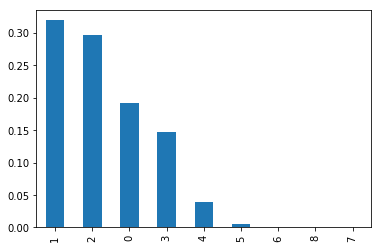

In [9]:
#First we start with a histogram...
train_df.bedrooms.value_counts(normalize=True).plot.bar()

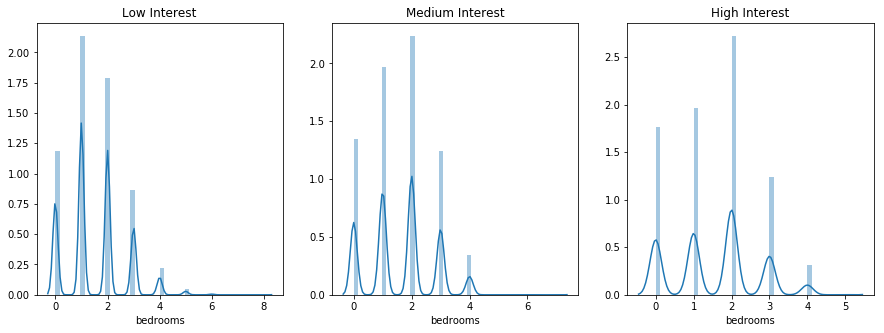

In [10]:
#How does bedrooms correlate with interest_level? Lets use histogram grouped by interest_level

plt.figure(figsize=(15,5))

# Histograms
plt.subplot(1,3,1)
plt.title("Low Interest")
sns.distplot(a=train_df[train_df['interest_level'] == 'low'].bedrooms, kde=True)
plt.subplot(1,3,2)
plt.title("Medium Interest")
sns.distplot(a=train_df[train_df['interest_level'] == 'medium'].bedrooms, kde=True)
plt.subplot(1,3,3)
plt.title("High Interest")
sns.distplot(a=train_df[train_df['interest_level'] == 'high'].bedrooms, kde=True)

Seems like medium and high interest levels tend to have more bedrooms... lets double check with a violin plot.

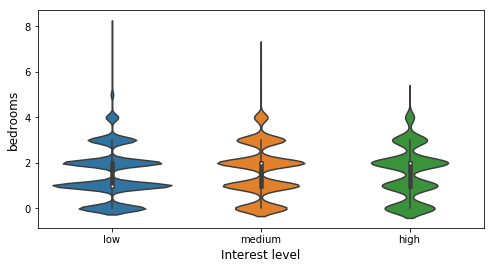

In [11]:
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bedrooms', data=train_df, order=['low','medium','high'])
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bedrooms', fontsize=12)
plt.show()

So distributions definitely look different for each interest level.

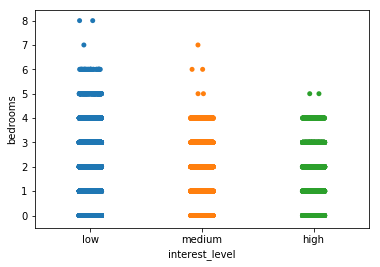

In [12]:
sns.stripplot(x="interest_level", y="bedrooms", data=train_df, order=['low','medium','high'])

Once again, we see a similar trend to bathrooms. People are not interested in houses with too many bedrooms (6+). High interest levels are capped at 5 bedrooms.

## Price

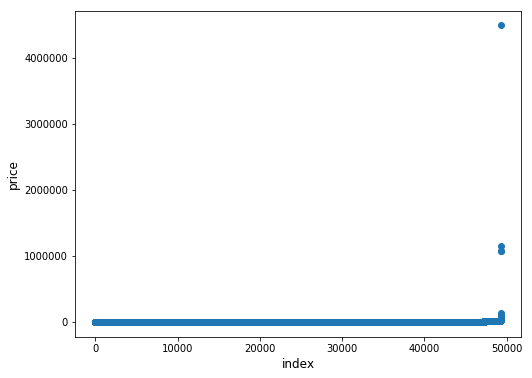

In [13]:
#First we plot a simple scatterplot to see all house prices
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

From the scatterplot above, we can see atleast 3 outliers. Let's remove them and then plot a histogram.

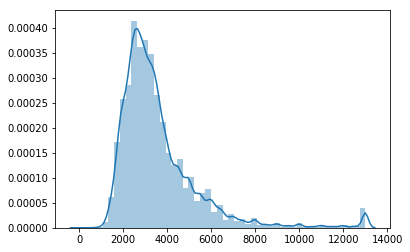

In [14]:
#We set an upper limit of 13000 which is what 99% of the data lies within.

ulimit = np.percentile(train_df.price.values, 99)
train_df.loc[train_df['price'] > ulimit, 'price'] = ulimit

sns.distplot(train_df.price.values, bins=50, kde=True)

So here we can see a right skew. It would be interesting to try different transformations of this feature later.

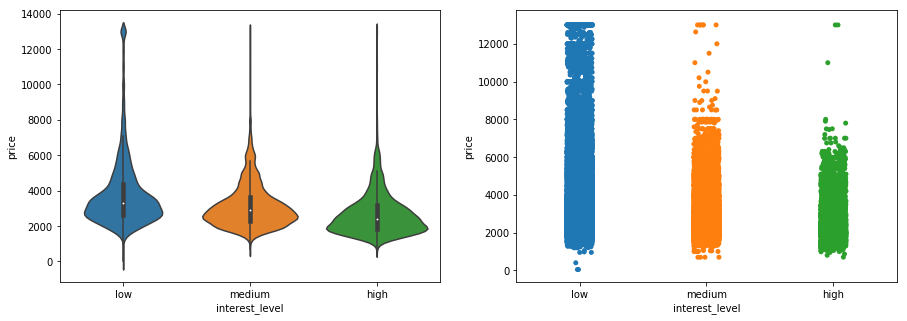

In [97]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.violinplot(x="interest_level", y="price", data=train_df, order=['low','medium','high'])
plt.subplot(1,2,2)
sns.stripplot(x="interest_level", y="price", data=train_df, order=['low','medium','high'])

Although it is really close, we can conclude that having a lower price has higher chances of showing high interest level. However, the boxplot also shows many outliers for every interest level, which indicates that price is not a deciding factor to gauge interest level.

## Latitude

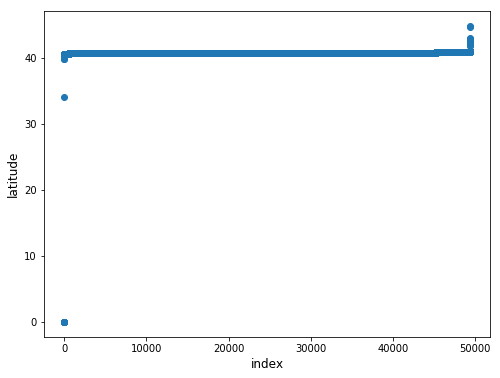

In [17]:
#First we plot a simple scatterplot to see all house prices
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.latitude.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('latitude', fontsize=12)
plt.show()

Alright, so we see a couple of outliers. Lets set an upper and lower limit and then plot a histogram.

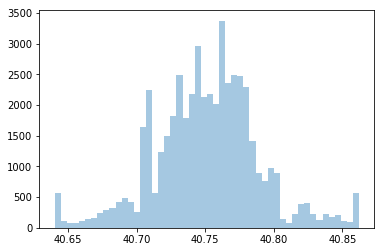

In [18]:
llimit = np.percentile(train_df.latitude.values, 1)
ulimit = np.percentile(train_df.latitude.values, 99)

train_df.loc[train_df['latitude'] < llimit, 'latitude'] = llimit
train_df.loc[train_df['latitude'] > ulimit, 'latitude'] = ulimit

sns.distplot(train_df.latitude.values, bins=50, kde=False)

So judging from this histogram we can say that most listings are between 40.6 - 40.9.

# Longitude

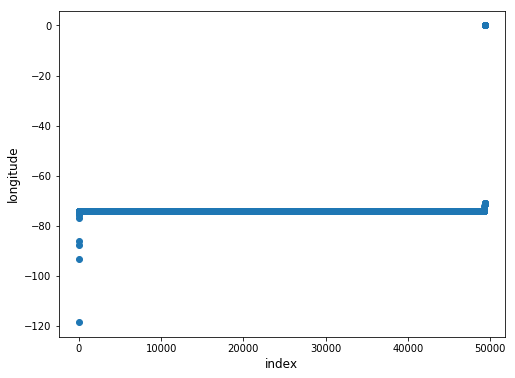

In [19]:
#First we plot a simple scatterplot to see all house prices
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.longitude.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('longitude', fontsize=12)
plt.show()

Once again, we see outliers. Let's set upper and lower limits.

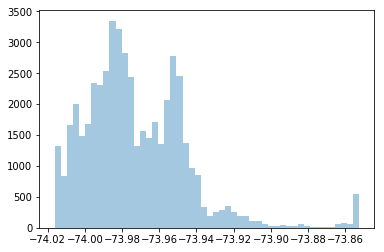

In [20]:
llimit = np.percentile(train_df.longitude.values, 1)
ulimit = np.percentile(train_df.longitude.values, 99)

train_df.loc[train_df['longitude'] < llimit, 'longitude'] = llimit
train_df.loc[train_df['longitude'] > ulimit, 'longitude'] = ulimit

sns.distplot(train_df.longitude.values, bins=50, kde=False)

Here we see that most houses were listed between -74 to -73.92

## Created

Okay, so the created feature gives us a lot of information. It tells us the exact year, month, day and time that every listing was posted.

In [21]:
#Create new features by breaking down the created feature
train_df["created"] = pd.to_datetime(train_df["created"])
train_df['date_created'] = train_df.created.dt.date
train_df['year_created'] = train_df.created.dt.year
train_df['month_created'] = train_df.created.dt.month
train_df['day_created'] = train_df.created.dt.day

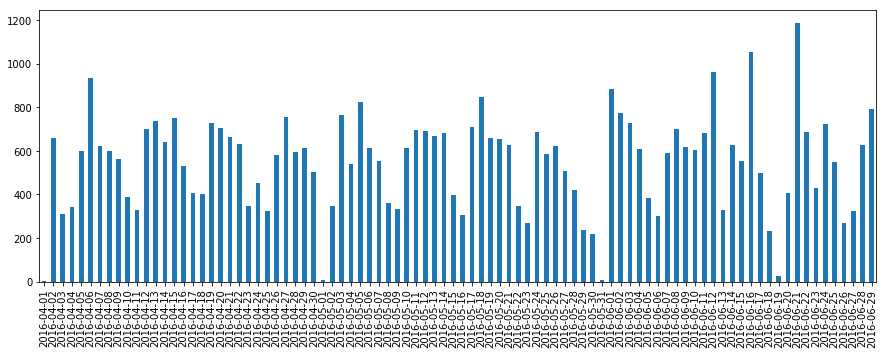

In [22]:
plt.figure(figsize=(15,5))
train_df.date_created.value_counts().sort_index().plot.bar()

There are a couple of things we can learn from this graph:
- All postings were uploaded in the year 2016 between April and July
- We can see this "seasonality" trend in which it looks like the first of every month has very little postings.

## Month

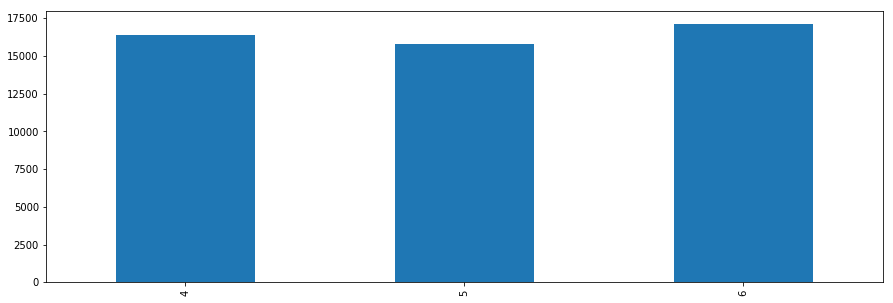

In [23]:
plt.figure(figsize=(15,5))
train_df.month_created.value_counts().sort_index().plot.bar()

So it seems that all months have roughly the same amount of postings. Lets take a look at interest level in each month.

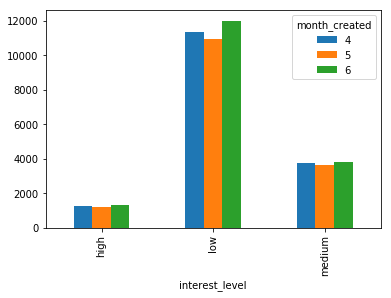

In [24]:
train_df.groupby('interest_level').month_created.value_counts().unstack().plot.bar()

Looks like each month has the same interest levels for all low, medium and high.

## Day

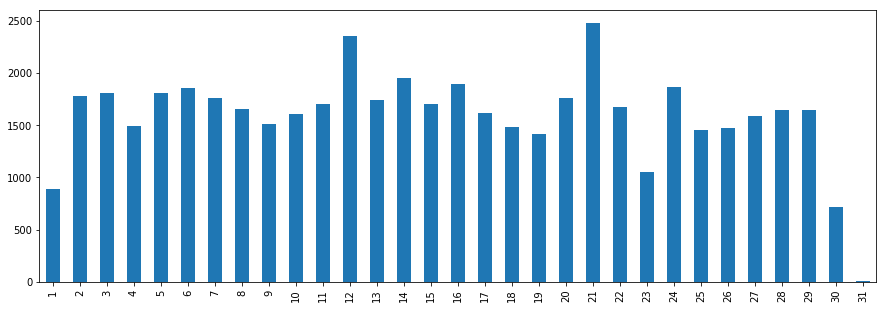

In [25]:
plt.figure(figsize=(15,5))
train_df.day_created.value_counts().sort_index().plot.bar()

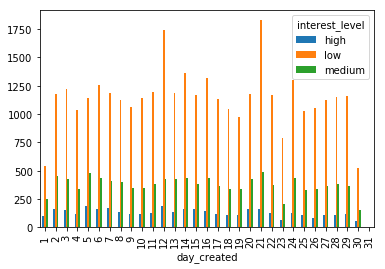

In [26]:
train_df.groupby(['day_created','interest_level'])['day_created'].count().unstack().plot.bar()

Seems like there isn't really a day trend. That is, all dates show relatively equal amounts of low, medium, and high interest levels.

## Photos

For this feature, instead of looking at the actual photo. We will create a new feature called "num_photos" which specifies how many photos were including in a particular listing. My hypothesis is that listings with more photos are more likely to show high interest.

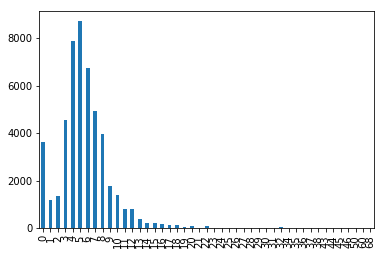

In [27]:
train_df['num_photos'] = train_df.photos.apply(len)

train_df.num_photos.value_counts().sort_index().plot.bar()

So, almost all listings have between 0-15 photos. There are some listings with over 15 photos. We will consider these outliers and remove them.

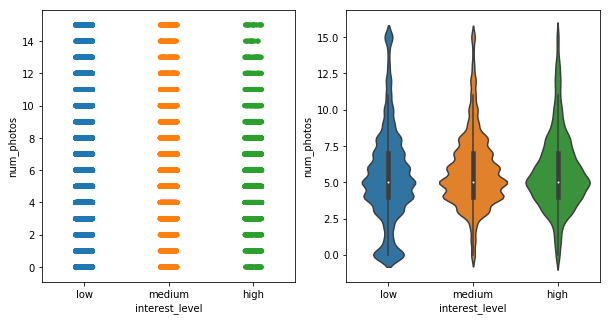

In [28]:
plt.figure(figsize=(10,5))
train_df.loc[train_df['num_photos'] > 15, 'num_photos'] = 15
plt.subplot(1,2,1)
sns.stripplot(x="interest_level", y="num_photos", data=train_df, order=['low','medium','high'])
plt.subplot(1,2,2)
sns.violinplot(x="interest_level",y='num_photos', data=train_df, order=['low','medium','high'])

My initial hypothesis was wrong. More photos does not mean higher interest level. But one thing we found is that listings with little photos (0 - 2) are more likely to show low interest.

## Features
We will create a new feature called "num_features" and perform analysis similar to the photos section above.

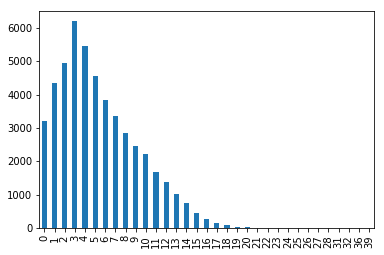

In [29]:
train_df['num_features'] = train_df.features.apply(len)

train_df.num_features.value_counts().sort_index().plot.bar()

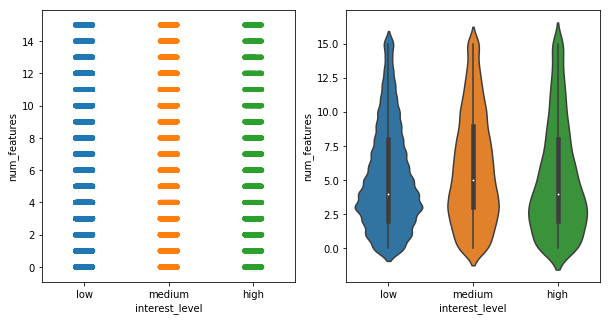

In [30]:
plt.figure(figsize=(10,5))
train_df.loc[train_df['num_features'] > 15, 'num_features'] = 15
plt.subplot(1,2,1)
sns.stripplot(x="interest_level", y="num_features", data=train_df, order=['low','medium','high'])
plt.subplot(1,2,2)
sns.violinplot(x="interest_level",y='num_features', data=train_df, order=['low','medium','high'])

Looks like even distribution accross all interest levels.

Continuing on with our features analysis, we will create a word cloud to see what the most popular features are.

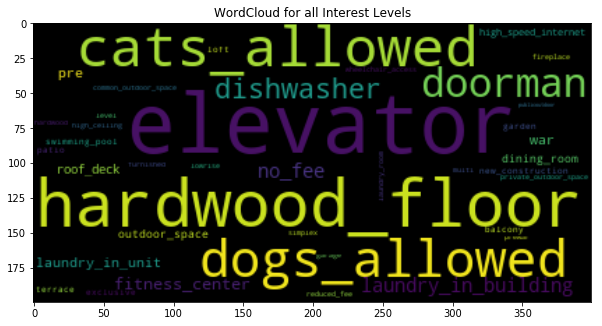

In [31]:
#What are the most popular features?
tmp = []
for feature_arr in train_df.features.values:
    if len(feature_arr) > 0:
        for features in feature_arr:
            tmp.append(('_'.join(features.split(' '))).lower())
string = ' '.join(tmp).strip()

wordcloud = WordCloud(max_words=40,collocations = False).generate(string)

# # Display the generated image:
plt.figure(figsize=(10,10))
plt.title("WordCloud for all Interest Levels")
plt.imshow(wordcloud, interpolation='bilinear')

Alright, so this wordcloud above shows the most popular features that were posted for every listing. Lets see if different interest levels have different features.

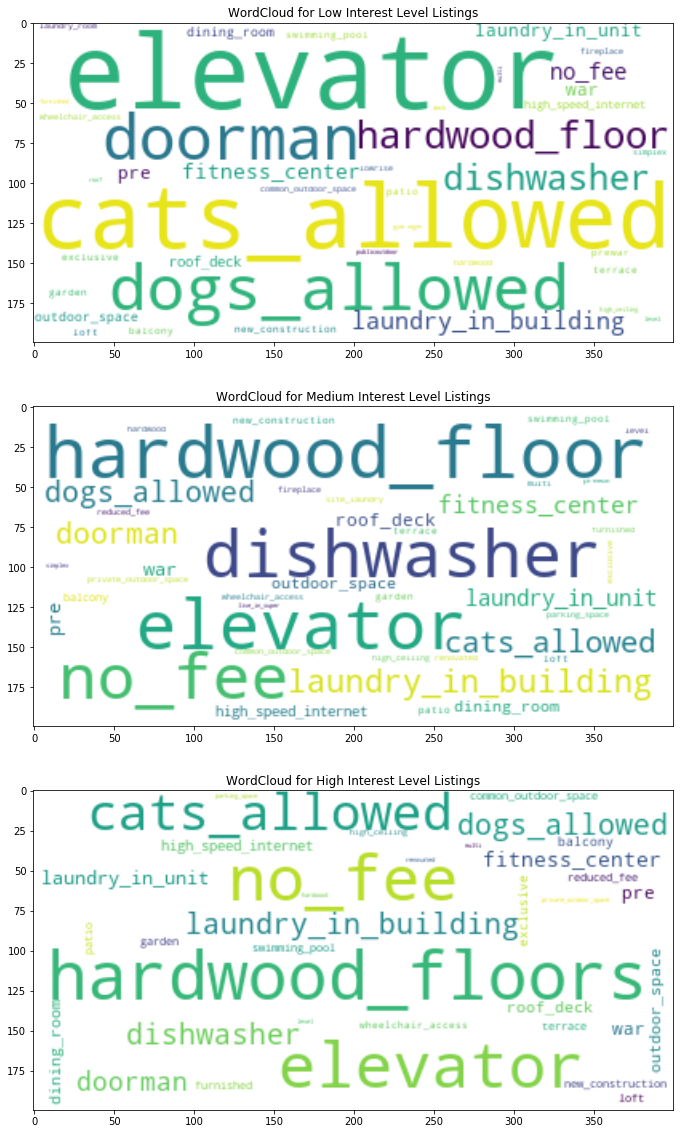

In [54]:
#LOW INTEREST
tmp_low = []
for feature_arr in train_df.loc[train_df['interest_level'] == 'low'].features.values:
    if len(feature_arr) > 0:
        for features in feature_arr:
            tmp_low.append(('_'.join(features.split(' '))).lower())
string_low = ' '.join(tmp_low).strip()

wordcloud_low = WordCloud(max_words=40,collocations = False, background_color="white").generate(string_low)

#MEDIUM INTEREST
tmp_med = []
for feature_arr in train_df.loc[train_df['interest_level'] == 'medium'].features.values:
    if len(feature_arr) > 0:
        for features in feature_arr:
            tmp_med.append(('_'.join(features.split(' '))).lower())
string_med = ' '.join(tmp_med).strip()

wordcloud_med = WordCloud(max_words=40,collocations = False, background_color="white").generate(string_med)

#HIGH INTEREST
tmp_high = []
for feature_arr in train_df.loc[train_df['interest_level'] == 'high'].features.values:
    if len(feature_arr) > 0:
        for features in feature_arr:
            tmp_high.append(('_'.join(features.split(' '))).lower())
string_high = ' '.join(tmp_high).strip()

wordcloud_high = WordCloud(max_words=40,collocations = False, background_color="white").generate(string_high)


# # Display the generated image:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.title("WordCloud for Low Interest Level Listings")
plt.imshow(wordcloud_low,interpolation='bilinear')

plt.subplot(3,1,2)
plt.title("WordCloud for Medium Interest Level Listings")
plt.imshow(wordcloud_med,interpolation='bilinear')

plt.subplot(3,1,3)
plt.title("WordCloud for High Interest Level Listings")
plt.imshow(wordcloud_high,interpolation='bilinear')

From these wordclouds we can conclude the following:
- Medium and High interest levels are looking for the 'no_fee' feature more often.
- Medium and High interest levels are looking for the 'hardwood_floors' feature more often.
- 'Dishwasher' is a popular feature for medium and high interest levels
- 'fitness_center' is a popular feature for high interest levels
- 'laundry_in_building' is a popular feature for high interest levels
- 'outdoor_space' is a popular feature for high interest levels

All in all, it seems that people show high interest for houses that include: dishwashers, fitness centers, laundry, hardwood floors and outdoor spaces.

## Manager ID
Now, it stands to reason that a good manager is more likely to achieve high interest levels, so lets see if we can find a trend within the ManagerID feature.

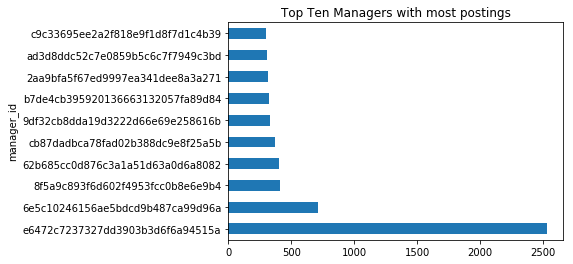

In [33]:
manager_df = train_df.groupby(['manager_id', 'interest_level'])['manager_id'].count().unstack().fillna(0)
manager_df['total'] = manager_df.sum(axis=1)

plt.figure()
plt.title("Top Ten Managers with most postings")
manager_df['total'].sort_values(ascending=False)[:10].plot(kind='barh')

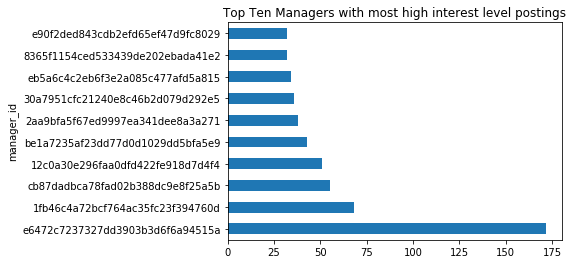

In [34]:
plt.figure()
plt.title("Top Ten Managers with most high interest level postings")
manager_df['high'].sort_values(ascending=False)[:10].plot(kind='barh')

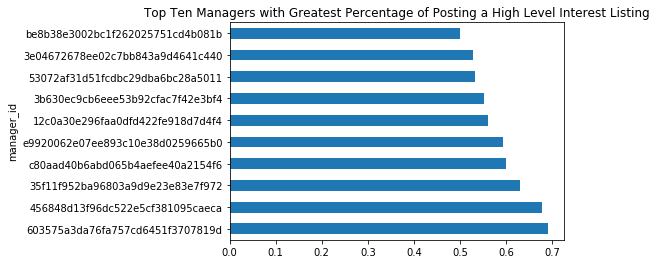

In [35]:
#Find top managers that have the best percentage of posting a high interest listing.
#Constrained to managers that have atleast 15 listings posted

manager_df['high_percentage'] = manager_df['high'] / manager_df['total']
plt.figure()
plt.title("Top Ten Managers with Greatest Percentage of Posting a High Level Interest Listing")
manager_df[manager_df['total'] >= 15].high_percentage.sort_values(ascending=False)[:10].plot(kind='barh')
# manager_df['high_percentage'].sort_values(ascending=False)[:10].plot(kind='barh')

Here, we see the managers with the best ratio of postings that are of high_interest level and who have atleast 15 listings posted.

## Description

Lets create a new feature "num_description", which specifies the amount of words in a given description post. We want to see if description length correlates to interest level.

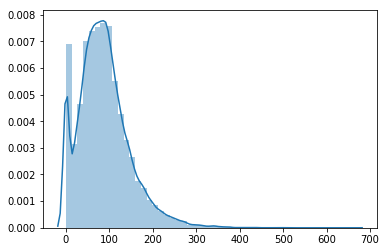

In [37]:
train_df['num_description'] = [len(x.split()) for x in train_df['description'].tolist()]
sns.distplot(train_df.num_description.values, bins=50, kde=True)

Most descriptions have between 0 - 300 words. Lets set an upper limit and then create a strip plot and violin plot to see the distribution grouped by interest levels.

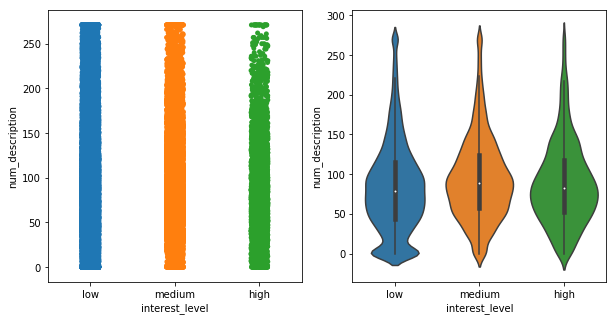

In [38]:
ulimit = np.percentile(train_df.num_description.values, 99)
train_df.loc[train_df['num_description'] > ulimit, 'num_description'] = ulimit

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.stripplot(x="interest_level", y="num_description", data=train_df, order=['low','medium','high'])
plt.subplot(1,2,2)
sns.violinplot(x="interest_level",y='num_description', data=train_df, order=['low','medium','high'])

Based on the graphs, we can conclude that postings with few description words are more likely to result in low interest levels. That being said however, more description words do not result in higher interest levels.

### Description Word Clouds

/Users/freemanmak/miniconda3/envs/python_3.6/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


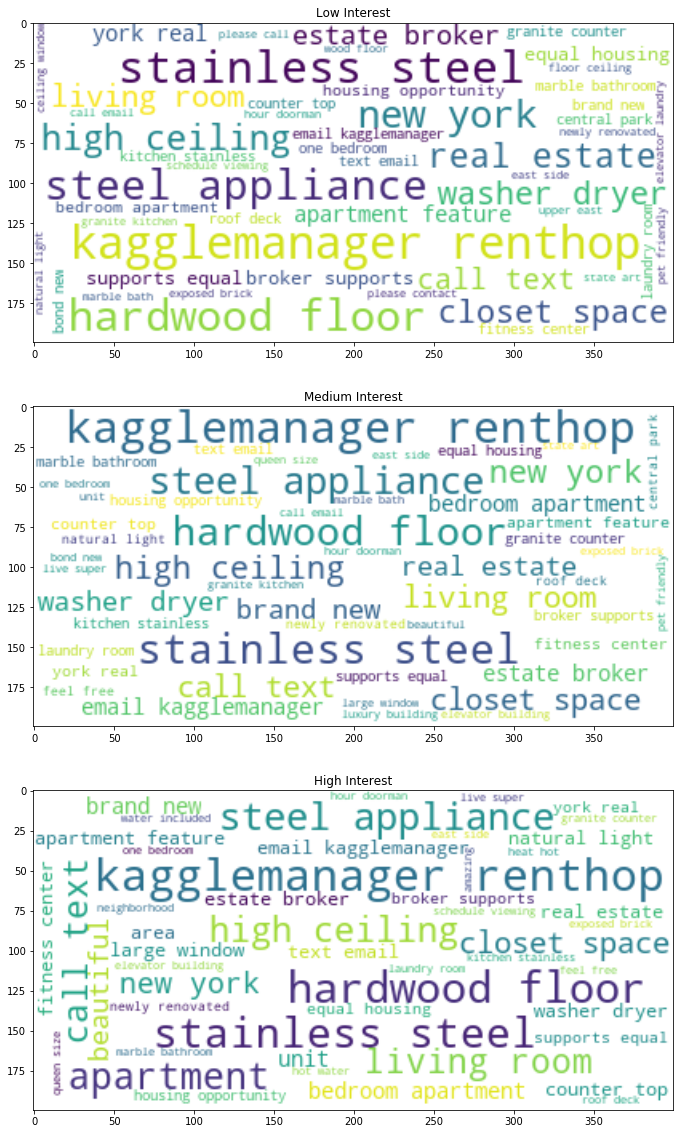

In [55]:
#LOW INTEREST
string_low = ''
for description in train_df.loc[train_df['interest_level'] == 'low'].description.values:
    #Use Beautiful Soup to Parse our HTML tags
    soup = BeautifulSoup(description, 'html.parser')
    string_low += soup.get_text()
    
#MEDIUM INTEREST
string_med = ''
for description in train_df.loc[train_df['interest_level'] == 'medium'].description.values:
    #Use Beautiful Soup to Parse our HTML tags
    soup = BeautifulSoup(description, 'html.parser')
    string_med += soup.get_text()
    
#HIGH INTEREST
string_high = ''
for description in train_df.loc[train_df['interest_level'] == 'high'].description.values:
    #Use Beautiful Soup to Parse our HTML tags
    soup = BeautifulSoup(description, 'html.parser')
    string_high += soup.get_text()


wordcloud_low = WordCloud(max_words=50,background_color="white").generate(string_low.lower().strip())
wordcloud_med = WordCloud(max_words=50,background_color="white").generate(string_med.lower().strip())
wordcloud_high = WordCloud(max_words=50,background_color="white").generate(string_high.lower().strip())

plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.title("Low Interest")
plt.imshow(wordcloud_low,interpolation='bilinear')
plt.subplot(3,1,2)
plt.title("Medium Interest")
plt.imshow(wordcloud_med,interpolation='bilinear')
plt.subplot(3,1,3)
plt.title("High Interest")
plt.imshow(wordcloud_high,interpolation='bilinear')

The wordclouds all seem very similar but one thing we see is that the high_interest groups have more of the keywords "brand new". This shows that people show high interest for listings that present a brand new apartment.

## Display Address

Its common knowledge that the real estate business is all about "location, location, location". Therefore, my initial hypothesis is that the display address will tell us a lot about the interest levels. In my experience, people tend to look at location first, before they consider any other features in apartment hunting.

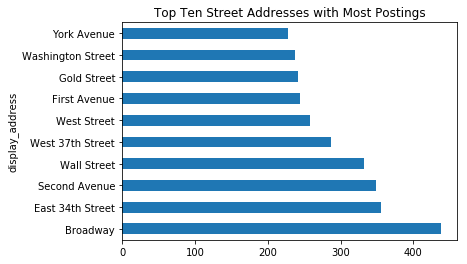

In [59]:
address_df = train_df.groupby(['display_address', 'interest_level'])['display_address'].count().unstack().fillna(0)
address_df['total'] = address_df.sum(axis=1)

plt.figure()
plt.title("Top Ten Street Addresses with Most Postings")
address_df['total'].sort_values(ascending=False)[:10].plot(kind='barh')

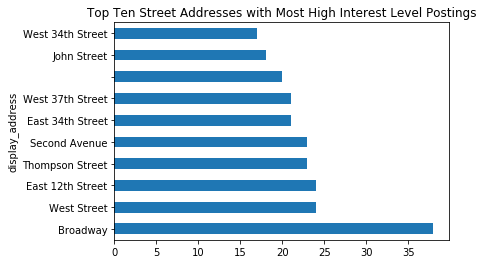

In [60]:
plt.figure()
plt.title("Top Ten Street Addresses with Most High Interest Level Postings")
address_df['high'].sort_values(ascending=False)[:10].plot(kind='barh')

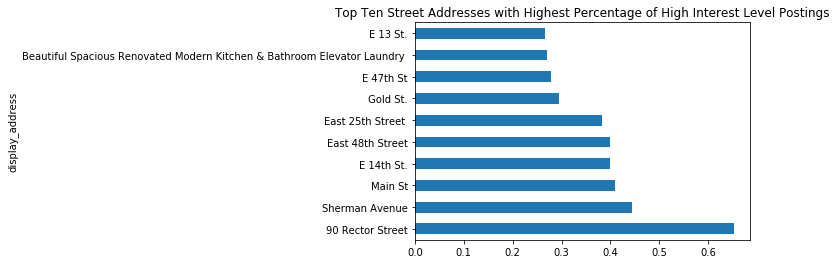

In [63]:
plt.figure()
plt.title("Top Ten Street Addresses with Highest Percentage of High Interest Level Postings")
address_df['high_percentage'] = address_df['high'] / address_df['total']
address_df[address_df['total'] >= 15].high_percentage.sort_values(ascending=False)[:10].plot(kind='barh')

## Building ID

Similar to the display addresss feature, the building ID specifies location.

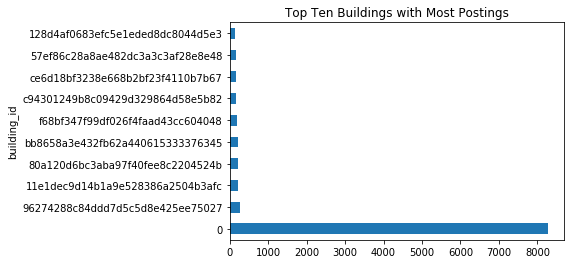

In [89]:
building_df = train_df.groupby(['building_id', 'interest_level'])['building_id'].count().unstack().fillna(0)
building_df['total'] = building_df.sum(axis=1)

plt.figure()
plt.title("Top Ten Buildings with Most Postings")
building_df['total'].sort_values(ascending=False)[:10].plot(kind='barh')

Alright, so **building_id = 0** clearly has the most postings. Chances are this is the default ID for when posters do not specify a specific building.

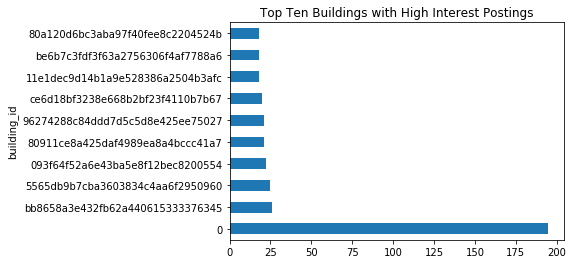

In [91]:
plt.figure()
plt.title("Top Ten Buildings with High Interest Postings")
building_df['high'].sort_values(ascending=False)[:10].plot(kind='barh')

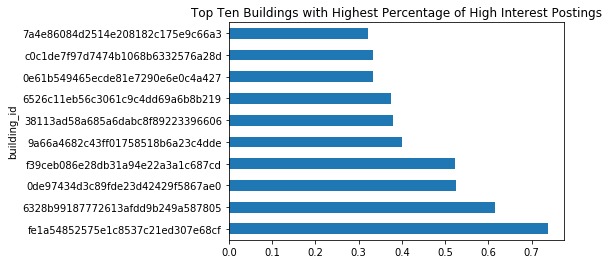

In [93]:
plt.figure()
plt.title("Top Ten Buildings with Highest Percentage of High Interest Postings")
building_df['high_percentage'] = building_df['high'] / building_df['total']
building_df[building_df['total'] >= 15]['high_percentage'].sort_values(ascending=False)[:10].plot(kind='barh')

# Data Exploration Findings:

The data exploration that we conducted revealed the following:
- **General:** A vast majority of postings are of low interest the split for low/med/high is roughly: %70/%20/%10
- **Bathrooms:** Listings with a lot of bathrooms (6+) tend to have low interest.
- **Bedrooms:** Listings with a lot of bedrooms (6+) tend to have low interest.
- **Price:** Pretty obvious, listings that ask for a lower price show higher interest.
- **Photos:** Listings that have no photos are more likely to have low interest.
- **Features:** Keywords like: **no_fee**, **hardwood_floors**, **dishwasher**, **fitness_center**, **outdoor_space** are more likely to show high interest.
- **Manager ID:** Identified 'high profile managers' that have a minimum of 15 postings and have a good percentage of posting high interest listings.
- **Description:** Found that the keywords: **Brand New** are presented a lot in high interest listings.
- **Display Address:** Found 'high profile addresses' that have a minimum of 15 postings and have a good percentage of high interest listings.
- **Building ID:** Found 'high profile buildings' that have a minimum of 15 postings and have a good percentage of high interest listings.